# ASL Final Models

This document has all of the models that we're including in our final project. 

## Loading & Prepping Data

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import metrics

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import numpy as np

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


2024-04-16 04:09:05.943775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 04:09:06.063021: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 04:09:06.068265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-16 04:09:06.068283: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [ ]:
#data from https://www.kaggle.com/datasets/datamunge/sign-language-mnist/data

asl_train =  pd.read_csv("sign_mnist_train.csv", low_memory = False)
asl_test =  pd.read_csv("sign_mnist_test.csv", low_memory = False)

In [ ]:
X_train = asl_train.iloc[:,1:]
Y_train = asl_train["label"]
X_test = asl_test.iloc[:,1:]
Y_test = asl_test["label"]
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)

X_train.shape: (27455, 784)
Y_train.shape: (27455,)
X_test.shape: (7172, 784)
Y_test.shape: (7172,)


In [ ]:
#reshaping data so it can be fed into a CNN. convert to numpy array first to reshape.abs
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)

X_train.shape: (27455, 28, 28, 1)
X_test.shape: (7172, 28, 28, 1)


In [ ]:
# Pixel values range from 0 to 255. To normalize the data, divide all values by 255.
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
#mapping numerical labels to the cooresponding alphabet label
alphabet = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F',
    6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L',
    12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
    18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X',
    24: 'Y', 25: 'Z'
}

In [ ]:
alphabet_filtered= [v for k, v in alphabet.items() if v not in ['J','Z']]

## Data Visualization

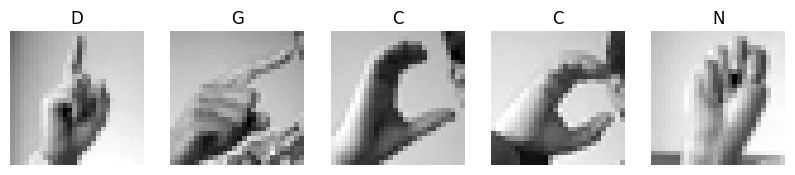

In [ ]:
#printing out the first few images
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,5))
for i in range(5):
  image = X_train[i]
  label = Y_train[i]
  alphabet_label = alphabet[label]
  axs[i].imshow(image, cmap='gray')
  axs[i].set_title(alphabet_label)
  axs[i].axis('off')
plt.show()

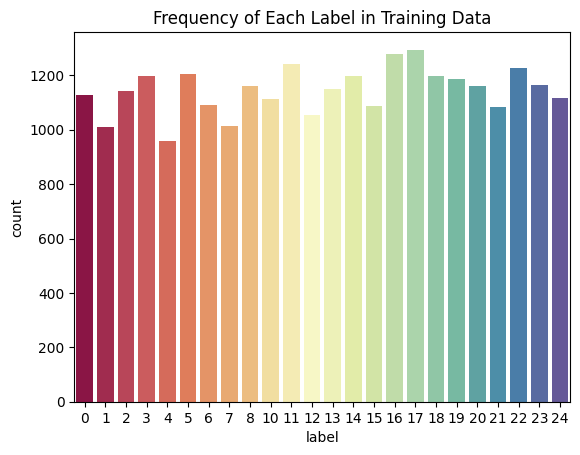

In [ ]:
# counting amount of occurances of each label

sns.countplot(asl_train, x = "label", hue = "label", palette = "Spectral", legend=None)
plt.title("Frequency of Each Label in Training Data")
plt.show()

## Data Augmentation

In [ ]:
def data_preprocessing(X, y):
    '''Apply transformations and augmentations to data    
    '''

    
# image augmentation on training data

    # adjust brightness
    X_augm = tf.image.random_brightness(X, 1, seed=None)

    # adjust contrast
    X_augm = tf.image.random_contrast(X, 0.1, 10)

    # random flip
    X_augm = tf.image.random_flip_left_right(X, 1234).numpy()

    # concatenate original X and augmented X_aug data
    X = tf.concat([X, X_augm], axis=0)

    # concatenate y_train (note the label is preserved)
    y_augm = Y_train
    y = tf.concat([y, y_augm],axis=0)

    # shuffle X and y, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
    X = tf.gather(X, shuffle).numpy() 
    y = tf.gather(y, shuffle).numpy()
        
        
    return X, y


X_train, Y_train = data_preprocessing(X_train, Y_train)

2024-04-15 17:32:22.285348: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-15 17:32:22.285383: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-15 17:32:22.285402: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-6496521d-ebd8-45fa-91d4-3cac81a166b5): /proc/driver/nvidia/version does not exist
2024-04-15 17:32:22.285696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Models

### Multi-class Logistic Regression

In [ ]:
mlr = keras.Sequential()
mlr.add(keras.layers.Flatten())
mlr.add(keras.layers.Dense(
    units= 25,
    activation= 'softmax'
))

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)

mlr.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

mlr_history = mlr.fit(
    x = X_train,
    y = Y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=1)

mlr_history = pd.DataFrame(mlr_history.history)

mlr_test_predictions = np.argmax(mlr.predict(X_test), axis=-1)
print(mlr_test_predictions)

display(mlr_history)

mlr_accuracy = accuracy_score(Y_test, mlr_test_predictions)
print("Accuracy:", mlr_accuracy)

Epoch 1/5
773/773 [==============================] - 3s 3ms/step - loss: 2.9470 - accuracy: 0.1731 - val_loss: 2.7197 - val_accuracy: 0.2424
Epoch 2/5
773/773 [==============================] - 2s 3ms/step - loss: 2.5507 - accuracy: 0.3603 - val_loss: 2.4406 - val_accuracy: 0.3562
Epoch 3/5
773/773 [==============================] - 2s 3ms/step - loss: 2.3173 - accuracy: 0.4330 - val_loss: 2.2552 - val_accuracy: 0.4507
Epoch 4/5
773/773 [==============================] - 2s 3ms/step - loss: 2.1552 - accuracy: 0.4730 - val_loss: 2.1227 - val_accuracy: 0.4305
Epoch 5/5
225/225 [==============================] - 0s 1ms/step
[ 6  5 10 ...  2  4  2]


,loss,accuracy,val_loss,val_accuracy
0,2.946983,0.173051,2.719742,0.242397
1,2.550703,0.360307,2.440551,0.356219
2,2.317316,0.432971,2.255244,0.450738
3,2.155165,0.472996,2.122724,0.430523
4,2.033287,0.500637,2.008380,0.497359


Accuracy: 0.506553262688232


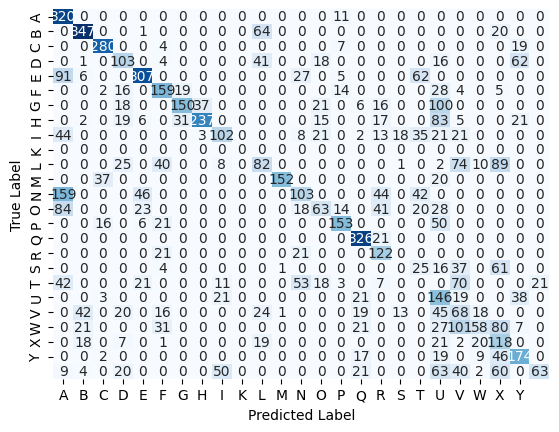

In [ ]:
mlr_confusion_matrix = tf.math.confusion_matrix(Y_test, mlr_test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(mlr_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels = alphabet_filtered, yticklabels = alphabet_filtered, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D

cnn = tf.keras.Sequential()

cnn.add(tf.keras.layers.Conv2D(
    filters=16,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))

cnn.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))

cnn.add(Dropout(0.25))

cnn.add(Conv2D(
    filters = 32, 
    kernel_size = (3,3),
    padding = 'same', 
    name='conv_2',
    activation ='relu'))

cnn.add(MaxPool2D(
    pool_size=(2,2),
    name = 'pool_2'))

cnn.add(Dropout(0.25))

cnn.add(Flatten())

cnn.add(Dense(200, activation = "relu"))

cnn.add(Dropout(0.5))

cnn.add(Dense(25, activation = "softmax"))

In [ ]:
cnn.build(input_shape= X_train.shape)

cnn.compile(optimizer=tf.keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

cnn_history = cnn.fit(x = X_train, y = Y_train, epochs= 5, validation_split=0.1)

Epoch 1/5
1545/1545 [==============================] - 79s 51ms/step - loss: 1.1988 - accuracy: 0.6155 - val_loss: 0.2262 - val_accuracy: 0.9472
Epoch 2/5
1545/1545 [==============================] - 78s 51ms/step - loss: 0.3894 - accuracy: 0.8668 - val_loss: 0.0866 - val_accuracy: 0.9823
Epoch 3/5
1545/1545 [==============================] - 77s 50ms/step - loss: 0.2443 - accuracy: 0.9161 - val_loss: 0.0308 - val_accuracy: 0.9969
Epoch 4/5
1545/1545 [==============================] - 77s 50ms/step - loss: 0.1820 - accuracy: 0.9382 - val_loss: 0.0134 - val_accuracy: 0.9982
Epoch 5/5
1545/1545 [==============================] - 76s 49ms/step - loss: 0.1426 - accuracy: 0.9509 - val_loss: 0.0102 - val_accuracy: 0.9993


In [ ]:
from sklearn.metrics import accuracy_score

cnn_history_df = pd.DataFrame(cnn_history.history)

cnn_test_predictions = np.argmax(cnn.predict(X_test), axis=-1)
print(cnn_test_predictions)

display(cnn_history_df)

cnn_accuracy = accuracy_score(Y_test, cnn_test_predictions)
print("Accuracy:", cnn_accuracy)

225/225 [==============================] - 3s 13ms/step
[ 6  5 10 ...  2  4  2]


,loss,accuracy,val_loss,val_accuracy
0,1.198839,0.615492,0.226218,0.947186
1,0.389396,0.866792,0.086630,0.982335
2,0.244277,0.916146,0.030832,0.996904
3,0.182046,0.938182,0.013416,0.998179
4,0.142595,0.950930,0.010217,0.999272


Accuracy: 0.939765755716676


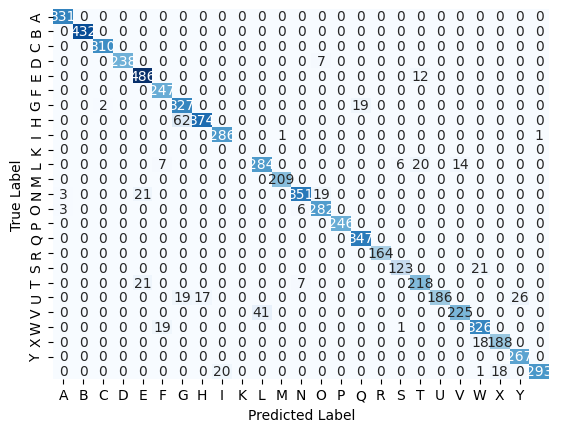

In [ ]:
cnn_confusion_matrix = tf.math.confusion_matrix(Y_test, cnn_test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(cnn_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels = alphabet_filtered, yticklabels = alphabet_filtered, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### LeNet-5

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.losses import CategoricalCrossentropy

X_train_pad = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test_pad = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

lenet = Sequential(name="LeNet-5")

lenet.add(Conv2D(6,(5,5),strides=(1,1), activation='tanh',input_shape=(32,32,1), name='C1')) # C1
lenet.add(AveragePooling2D(name='S2'))# S2
lenet.add(Conv2D(16,(5,5),strides=(1,1),activation='tanh',name='C3')) #C3
lenet.add(AveragePooling2D(name='S4')) #S4
lenet.add(Flatten())
lenet.add(Dense(120,activation='tanh',name='FC5')) #FC5
lenet.add(Dense(84,activation='tanh',name='FC6')) #FC6
lenet.add(Dense(25,activation='softmax',name='Output')) #FC7

lenet.compile(optimizer='adam',loss= keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

lenet_history = lenet.fit(X_train_pad, Y_train, validation_split=0.1, epochs=5)

Epoch 1/5
1545/1545 [==============================] - 52s 33ms/step - loss: 1.0030 - accuracy: 0.7172 - val_loss: 0.2973 - val_accuracy: 0.9399
Epoch 2/5
1545/1545 [==============================] - 54s 35ms/step - loss: 0.1196 - accuracy: 0.9835 - val_loss: 0.0436 - val_accuracy: 0.9969
Epoch 3/5
1545/1545 [==============================] - 52s 33ms/step - loss: 0.0236 - accuracy: 0.9985 - val_loss: 0.0108 - val_accuracy: 0.9998
Epoch 4/5
1545/1545 [==============================] - 52s 34ms/step - loss: 0.0055 - accuracy: 0.9999 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 5/5
1545/1545 [==============================] - 52s 34ms/step - loss: 0.0269 - accuracy: 0.9928 - val_loss: 0.0029 - val_accuracy: 1.0000


In [ ]:
lenet_history_df = pd.DataFrame(lenet_history.history)

lenet_test_predictions = np.argmax(lenet.predict(X_test_pad), axis=-1)
print(lenet_test_predictions)

display(lenet_history_df)

lenet_accuracy = accuracy_score(Y_test, lenet_test_predictions)
print("Accuracy:", lenet_accuracy)

225/225 [==============================] - 3s 12ms/step
[ 6  5 10 ...  2  4  2]


,loss,accuracy,val_loss,val_accuracy
0,1.002983,0.717174,0.297297,0.939902
1,0.119573,0.983529,0.043626,0.996904
2,0.023562,0.998503,0.010841,0.999818
3,0.005496,0.999879,0.003149,1.000000
4,0.026886,0.992837,0.002884,1.000000


Accuracy: 0.8098159509202454


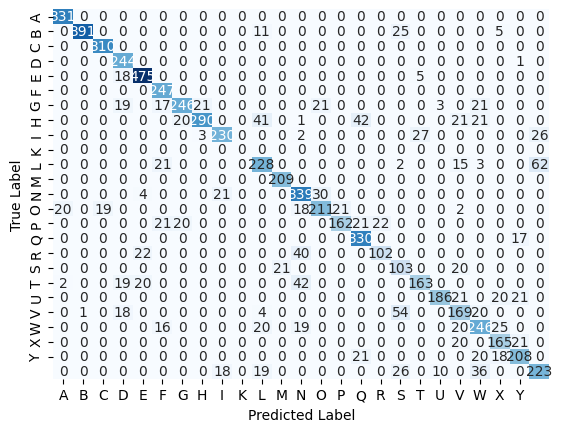

In [ ]:
lenet_confusion_matrix = tf.math.confusion_matrix(Y_test, lenet_test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(lenet_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels = alphabet_filtered, yticklabels = alphabet_filtered, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1), activation='relu'):
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation(activation)(y)
    
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=(1, 1), padding='same')(y)
    y = layers.BatchNormalization()(y)
    
    if strides != (1, 1) or x.shape[-1] != filters:
        x = layers.Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(x)
        x = layers.BatchNormalization()(x)
    
    out = layers.Add()([x, y])
    out = layers.Activation(activation)(out)
    
    return out

def ResNet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    
    x = residual_block(x, filters=128, strides=(2, 2))
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)
    
    x = residual_block(x, filters=256, strides=(2, 2))
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, x)
    return model

input_shape = (28, 28, 1)
num_classes = 25

model = ResNet(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

resnet_history = model.fit(X_train, Y_train, epochs=5, validation_split=0.1, batch_size=32)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 14, 14, 64)   0           ['batch_normalization[0][0]']

In [ ]:
resnet_history_df = pd.DataFrame(resnet_history.history)

resnet_test_predictions = np.argmax(model.predict(X_test), axis=-1)
print(resnet_test_predictions)

display(resnet_history_df)

resnet_accuracy = accuracy_score(Y_test, resnet_test_predictions)
print("Accuracy:", resnet_accuracy)

225/225 [==============================] - 17s 76ms/step
[ 6  5 10 ... 14  4 14]


,loss,accuracy,val_loss,val_accuracy
0,0.309327,0.899694,0.119407,0.960117
1,0.043442,0.986726,0.118497,0.960299
2,0.034910,0.989984,0.055421,0.982153
3,0.025707,0.992189,0.008980,0.997268
4,0.019172,0.994779,0.071978,0.979239


Accuracy: 0.9148075850529839


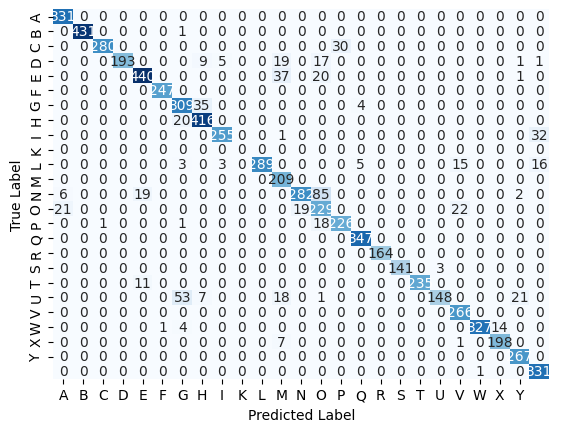

In [ ]:
resnet_confusion_matrix = tf.math.confusion_matrix(Y_test, resnet_test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(resnet_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels = alphabet_filtered, yticklabels = alphabet_filtered, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### EfficientNet

In [ ]:
from keras.applications import EfficientNetB0

effnet = EfficientNetB0(
    include_top = True,
    weights = None,
    classes = 25,
    input_shape = (32, 32, 1),
)

effnet.compile(optimizer = "adam", loss = keras.losses.SparseCategoricalCrossentropy(), metrics = ["accuracy"])

effnet.summary()

effnet_history = effnet.fit(X_train_pad,Y_train, validation_split=0.1, epochs=5, batch_size = 64)

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 32, 32, 1)    0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 32, 32, 1)   3           ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 1)    0           ['normalization_1[0]

In [ ]:
effnet_history_df = pd.DataFrame(effnet_history.history)

effnet_test_predictions = np.argmax(effnet.predict(X_test_pad), axis=-1)
print(effnet_test_predictions)

display(effnet_history_df)

effnet_accuracy = accuracy_score(Y_test, effnet_test_predictions)
print("Accuracy:", effnet_accuracy)

225/225 [==============================] - 20s 83ms/step
[ 6  5 10 ...  2  4  2]


,loss,accuracy,val_loss,val_accuracy
0,2.381538,0.385398,1.829865,0.417046
1,0.777317,0.804083,1.136731,0.824076
2,0.596957,0.859305,0.528075,0.865780
3,0.522055,0.884660,0.173806,0.963577
4,0.258512,0.943949,0.060143,0.987798


Accuracy: 0.7943390964863357


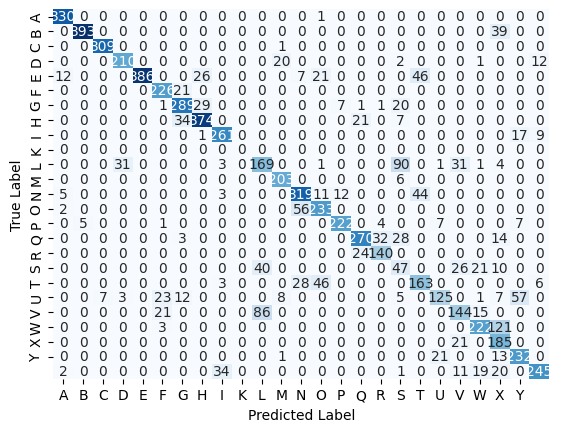

In [ ]:
effnet_confusion_matrix = tf.math.confusion_matrix(Y_test, effnet_test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(effnet_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels = alphabet_filtered, yticklabels = alphabet_filtered, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### RCNN

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.models import Model


def create_rcnn(input_shape, num_classes):
    # Input Layer
    inputs = Input(shape=input_shape)

    # Convolutional layers
    conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    dropout1 = Dropout(0.25)(pool1)
    conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(dropout1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    dropout2 = Dropout(0.25)(pool2)

    # Reshaping Layer for LSTM 
    reshape = tf.keras.layers.Reshape((7, 7 * 64))(dropout2)  

    # Recurrent (LSTM) layer
    lstm = LSTM(128, return_sequences=True)(reshape)
    lstm = LSTM(64)(lstm)  
    dropout3 = Dropout(0.5)(lstm)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(dropout3)

    # Creating model
    model = Model(inputs=inputs, outputs=outputs)
    return model


input_shape = (28, 28, 1)
num_classes = 25 

# Creating RCNN model
rcnn_model = create_rcnn(input_shape, num_classes)

#Compile using Adam Optimizer
rcnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rcnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                         

In [ ]:
rcnn_history = rcnn_model.fit(x = X_train, y = Y_train, epochs = 5, batch_size = 32, validation_split=0.1)

Epoch 1/5
1545/1545 [==============================] - 185s 118ms/step - loss: 1.5388 - accuracy: 0.5024 - val_loss: 0.3032 - val_accuracy: 0.8987
Epoch 2/5
1545/1545 [==============================] - 175s 113ms/step - loss: 0.2978 - accuracy: 0.9052 - val_loss: 0.0503 - val_accuracy: 0.9867
Epoch 3/5
1545/1545 [==============================] - 179s 116ms/step - loss: 0.1195 - accuracy: 0.9652 - val_loss: 0.0127 - val_accuracy: 0.9973
Epoch 4/5
1545/1545 [==============================] - 175s 113ms/step - loss: 0.0753 - accuracy: 0.9791 - val_loss: 0.0089 - val_accuracy: 0.9969
Epoch 5/5
1545/1545 [==============================] - 176s 114ms/step - loss: 0.0545 - accuracy: 0.9851 - val_loss: 0.0065 - val_accuracy: 0.9984


In [ ]:
rcnn_history_df = pd.DataFrame(rcnn_history.history)

rcnn_test_predictions = np.argmax(rcnn_model.predict(X_test), axis=-1)
print(rcnn_test_predictions)

display(rcnn_history_df)

rcnn_accuracy = accuracy_score(Y_test, rcnn_test_predictions)
print("Accuracy:", rcnn_accuracy)

225/225 [==============================] - 6s 28ms/step
[ 6  5 10 ...  2  4  2]


,loss,accuracy,val_loss,val_accuracy
0,1.538776,0.502418,0.303186,0.898743
1,0.297839,0.905158,0.050343,0.986706
2,0.119459,0.965216,0.012659,0.997268
3,0.075318,0.979097,0.008892,0.996904
4,0.054452,0.985107,0.006497,0.998361


Accuracy: 0.9510596765197992


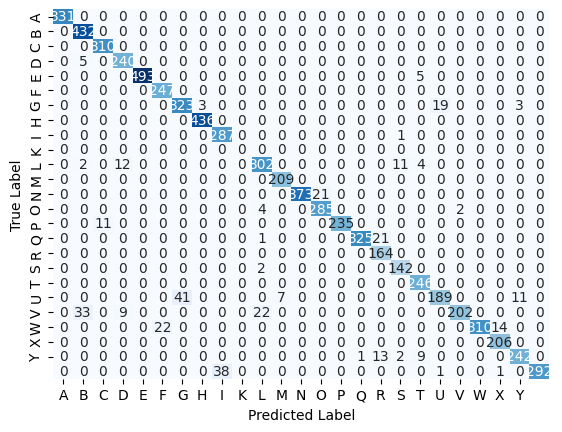

In [ ]:
rcnn_confusion_matrix = tf.math.confusion_matrix(Y_test, rcnn_test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(rcnn_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels = alphabet_filtered, yticklabels = alphabet_filtered, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### Simple Neural Network (Multilayer Perceptron)

In [ ]:
#using hidden layer size of [256, 128], activation relu, optimizer Adam, and learning rate of 0.01
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):

  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  model = keras.Sequential()
  #input layer with shape of images
  model.add(keras.layers.Flatten())
  #hidden layer
  for hidden_layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                        activation=activation))
  #output layer using softmax since it's multiclass logistic regression
  model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax', name='Output'))
  #categorical_crossentropy loss for multiclass regression
  if optimizer.lower() == 'adam':
      optim = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  elif optimizer.lower() == 'sgd':
      optim = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

  return model



# Build the model.
nn = build_model(n_classes=25,
                    hidden_layer_sizes=[256,128],
                    activation='relu',
                    optimizer='Adam',
                    learning_rate=0.01)

# Train the model.
nn_history = nn.fit(
    x= X_train,
    y= Y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=0)

In [ ]:
nn_history_df = pd.DataFrame(nn_history.history)

nn_test_predictions = np.argmax(nn.predict(X_test), axis=-1)
print(nn_test_predictions)

display(nn_history_df)

nn_accuracy = accuracy_score(Y_test, nn_test_predictions)
print("Accuracy:", nn_accuracy)

225/225 [==============================] - 1s 2ms/step
[ 6  5 19 ...  2  4  2]


,loss,accuracy,val_loss,val_accuracy
0,2.383768,0.232421,2.121890,0.304316
1,1.446652,0.493838,1.280969,0.541249
2,1.088041,0.617313,1.227479,0.567838
3,0.929827,0.675651,1.008666,0.666545
4,0.810726,0.716971,1.138550,0.617192


Accuracy: 0.4626324595649749


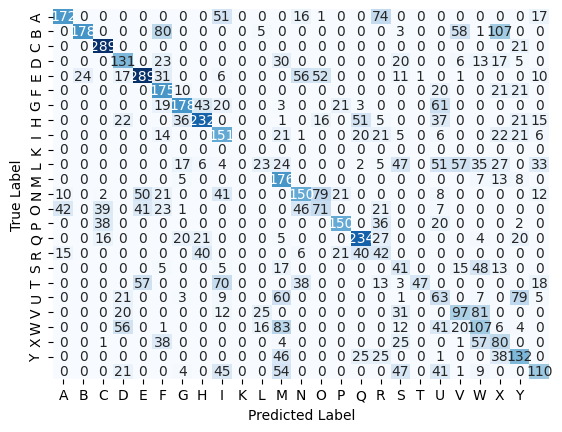

In [ ]:
nn_confusion_matrix = tf.math.confusion_matrix(Y_test, nn_test_predictions)

ax = sns.heatmap(nn_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels = alphabet_filtered, yticklabels = alphabet_filtered, cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### SqueezeNet

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def fire_module(x, squeeze_filters, expand_filters, use_dropout=False, dropout_rate=0.5, weight_decay=0.0002):
    squeeze = Conv2D(squeeze_filters, (1, 1), activation='relu', padding='same', 
                     kernel_regularizer=l2(weight_decay))(x)
    squeeze = BatchNormalization()(squeeze)
    
    expand_1x1 = Conv2D(expand_filters, (1, 1), activation='relu', padding='same',
                        kernel_regularizer=l2(weight_decay))(squeeze)
    expand_1x1 = BatchNormalization()(expand_1x1)
    
    expand_3x3 = Conv2D(expand_filters, (3, 3), activation='relu', padding='same',
                        kernel_regularizer=l2(weight_decay))(squeeze)
    expand_3x3 = BatchNormalization()(expand_3x3)
    
    output = Concatenate()([expand_1x1, expand_3x3])
    
    if use_dropout:
        output = Dropout(dropout_rate)(output)
    
    return output

def SqueezeNet(input_shape=(28, 28, 1), num_classes=25, weight_decay=0.0002):
    input_tensor = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='valid', 
               kernel_regularizer=l2(weight_decay))(input_tensor)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=16, expand_filters=64, use_dropout=True, weight_decay=weight_decay)
    x = fire_module(x, squeeze_filters=16, expand_filters=64, use_dropout=True, weight_decay=weight_decay)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=32, expand_filters=128, use_dropout=True, weight_decay=weight_decay)
    x = fire_module(x, squeeze_filters=32, expand_filters=128, use_dropout=True, weight_decay=weight_decay)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=48, expand_filters=192, use_dropout=True, weight_decay=weight_decay)
    x = fire_module(x, squeeze_filters=48, expand_filters=192, use_dropout=True, weight_decay=weight_decay)
    x = fire_module(x, squeeze_filters=64, expand_filters=256, use_dropout=True, weight_decay=weight_decay)
    x = fire_module(x, squeeze_filters=64, expand_filters=256, use_dropout=True, weight_decay=weight_decay)

    x = GlobalAveragePooling2D()(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)
    return model

def lr_scheduler(epoch, lr):
    if epoch > 0 and epoch % 10 == 0:
        return lr * 0.1
    return lr

scheduler = LearningRateScheduler(lr_scheduler)

data_augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


initial_learning_rate = 0.01
squeeze = SqueezeNet(input_shape=(28, 28, 1), num_classes=25)
squeeze.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

squeeze.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_25 (Conv2D)             (None, 13, 13, 64)   640         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 7, 7, 64)    0           ['conv2d_25[0][0]']              
                                                                                                  
 conv2d_26 (Conv2D)             (None, 7, 7, 16)     1040        ['max_pooling2d_3[0][0]']        
                                                                                            

In [ ]:
squeeze_history = squeeze.fit(
    data_augmentation.flow(X_train, Y_train, batch_size=32),
    epochs=30, 
    validation_data=(X_test, Y_test),
    callbacks=[scheduler] 
)

Epoch 1/30
1716/1716 [==============================] - 247s 144ms/step - loss: 0.5212 - accuracy: 0.8975 - val_loss: 0.3968 - val_accuracy: 0.9427 - lr: 1.0000e-04
Epoch 2/30
1716/1716 [==============================] - 246s 144ms/step - loss: 0.5165 - accuracy: 0.8969 - val_loss: 0.3906 - val_accuracy: 0.9446 - lr: 1.0000e-04
Epoch 3/30
1716/1716 [==============================] - 247s 144ms/step - loss: 0.5143 - accuracy: 0.8970 - val_loss: 0.4022 - val_accuracy: 0.9340 - lr: 1.0000e-04
Epoch 4/30
1716/1716 [==============================] - 247s 144ms/step - loss: 0.5030 - accuracy: 0.8997 - val_loss: 0.3882 - val_accuracy: 0.9393 - lr: 1.0000e-04
Epoch 5/30
1716/1716 [==============================] - 253s 147ms/step - loss: 0.4991 - accuracy: 0.9012 - val_loss: 0.3792 - val_accuracy: 0.9444 - lr: 1.0000e-04
Epoch 6/30
1716/1716 [==============================] - 248s 145ms/step - loss: 0.4971 - accuracy: 0.9021 - val_loss: 0.3756 - val_accuracy: 0.9444 - lr: 1.0000e-04
Epoch 7/30

In [ ]:
squeeze_history_df = pd.DataFrame(squeeze_history.history)

squeeze_test_predictions = np.argmax(squeeze.predict(X_test), axis=-1)
print(squeeze_test_predictions)

display(squeeze_history_df)

squeeze_accuracy = accuracy_score(Y_test, squeeze_test_predictions)
print("Accuracy:", squeeze_accuracy)

225/225 [==============================] - 5s 23ms/step
[ 6  5 10 ...  2  4  2]


,loss,accuracy,val_loss,val_accuracy,lr
0,0.521214,0.897469,0.396801,0.942694,9.999999e-05
1,0.516526,0.896922,0.390584,0.944646,9.999999e-05
2,0.514275,0.897031,0.402184,0.934049,9.999999e-05
3,0.502985,0.899745,0.388171,0.939347,9.999999e-05
4,0.499138,0.901184,0.379245,0.944367,9.999999e-05
5,0.497115,0.902094,0.375631,0.944367,9.999999e-05
6,0.489058,0.902459,0.376830,0.941857,9.999999e-05
7,0.486922,0.901803,0.361073,0.949386,9.999999e-05
8,0.486028,0.901803,0.358384,0.950920,9.999999e-05
9,0.481117,0.904189,0.372001,0.934746,9.999999e-05


Accuracy: 0.9488287785833798


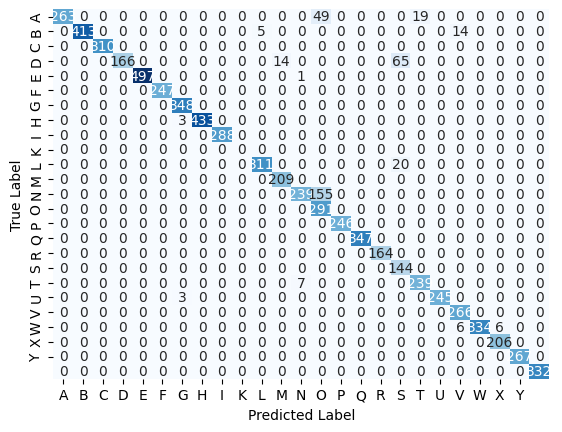

In [ ]:
squeeze_confusion_matrix = tf.math.confusion_matrix(Y_test, squeeze_test_predictions)

ax = sns.heatmap(squeeze_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels = alphabet_filtered, yticklabels = alphabet_filtered, cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### Enhanced SqueezeNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Concatenate, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

def fire_module(x, squeeze_filters, expand_filters, use_dropout=False, dropout_rate=0.5, weight_decay=0.0001):
    squeeze = Conv2D(squeeze_filters, (1, 1), activation='relu', padding='same',
                     kernel_regularizer=l2(weight_decay))(x)
    squeeze = BatchNormalization()(squeeze)
    
    expand_1x1 = Conv2D(expand_filters, (1, 1), activation='relu', padding='same',
                        kernel_regularizer=l2(weight_decay))(squeeze)
    expand_1x1 = BatchNormalization()(expand_1x1)
    
    expand_3x3 = Conv2D(expand_filters, (3, 3), activation='relu', padding='same',
                        kernel_regularizer=l2(weight_decay))(squeeze)
    expand_3x3 = BatchNormalization()(expand_3x3)
    
    output = Concatenate()([expand_1x1, expand_3x3])
    
    if use_dropout:
        output = Dropout(dropout_rate)(output)
    
    return output

def enhanced_SqueezeNet(input_shape=(28, 28, 1), num_classes=25, weight_decay=0.0001):
    input_tensor = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='valid',
               kernel_regularizer=l2(weight_decay))(input_tensor)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=16, expand_filters=64, use_dropout=True, weight_decay=weight_decay)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=32, expand_filters=128, use_dropout=True, weight_decay=weight_decay)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=48, expand_filters=192, use_dropout=True, weight_decay=weight_decay)
    x = fire_module(x, squeeze_filters=64, expand_filters=256, use_dropout=True, weight_decay=weight_decay)

    x = GlobalAveragePooling2D()(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)
    return model

def lr_scheduler(epoch, lr):
    if epoch >= 5:
        return lr * 0.2
    return lr

initial_learning_rate = 0.001
en_squeeze = enhanced_SqueezeNet(input_shape=(28, 28, 1), num_classes=25)
en_squeeze.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

data_augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size = 32
epochs = 10 

In [ ]:
en_squeeze_history = en_squeeze.fit(
    data_augmentation.flow(X_train, Y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    validation_data=(X_test, Y_test),
    callbacks=[LearningRateScheduler(lr_scheduler)]
)

Epoch 1/10
1715/1715 [==============================] - 164s 95ms/step - loss: 2.0135 - accuracy: 0.3784 - val_loss: 1.0652 - val_accuracy: 0.6567 - lr: 0.0010
Epoch 2/10
1715/1715 [==============================] - 162s 95ms/step - loss: 0.9599 - accuracy: 0.6946 - val_loss: 1.5914 - val_accuracy: 0.5301 - lr: 0.0010
Epoch 3/10
1715/1715 [==============================] - 162s 94ms/step - loss: 0.7278 - accuracy: 0.7832 - val_loss: 3.4667 - val_accuracy: 0.2164 - lr: 0.0010
Epoch 4/10
1715/1715 [==============================] - 159s 93ms/step - loss: 0.6271 - accuracy: 0.8283 - val_loss: 0.5832 - val_accuracy: 0.8634 - lr: 0.0010
Epoch 5/10
1715/1715 [==============================] - 156s 91ms/step - loss: 0.5737 - accuracy: 0.8515 - val_loss: 2.2699 - val_accuracy: 0.4004 - lr: 0.0010
Epoch 6/10
1715/1715 [==============================] - 157s 92ms/step - loss: 0.4403 - accuracy: 0.9011 - val_loss: 0.6694 - val_accuracy: 0.8155 - lr: 2.0000e-04
Epoch 7/10
1715/1715 [==============

In [ ]:
en_squeeze_history_df = pd.DataFrame(en_squeeze_history.history)

en_squeeze_test_predictions = np.argmax(en_squeeze.predict(X_test), axis=-1)
print(en_squeeze_test_predictions)

display(en_squeeze_history_df)

en_squeeze_accuracy = accuracy_score(Y_test, en_squeeze_test_predictions)
print("Accuracy:", en_squeeze_accuracy)

225/225 [==============================] - 3s 13ms/step
[6 5 3 ... 2 4 2]


,loss,accuracy,val_loss,val_accuracy,lr
0,2.013545,0.378383,1.065205,0.656721,1.000000e-03
1,0.959876,0.694609,1.591359,0.530117,1.000000e-03
2,0.727841,0.783245,3.466749,0.216397,1.000000e-03
3,0.627112,0.828283,0.583215,0.863357,1.000000e-03
4,0.573748,0.851539,2.269927,0.400446,1.000000e-03
5,0.440334,0.901056,0.669370,0.815533,2.000000e-04
6,0.393532,0.916081,0.470932,0.881065,4.000000e-05
7,0.381940,0.919377,0.440990,0.893335,8.000001e-06
8,0.377697,0.920288,0.425353,0.899610,1.600000e-06
9,0.383490,0.917938,0.417362,0.904071,3.200000e-07


Accuracy: 0.9040713887339654


### RNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

rnn = Sequential([
    SimpleRNN(64, input_shape=(28, 28)), 
    Dense(25, activation='softmax')  
])

rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rnn.summary()

rnn_history = rnn.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                5952      
                                                                 
 dense_4 (Dense)             (None, 25)                1625      
                                                                 
Total params: 7,577
Trainable params: 7,577
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1716/1716 [==============================] - 32s 18ms/step - loss: 2.2042 - accuracy: 0.3052 - val_loss: 1.8812 - val_accuracy: 0.4018
Epoch 2/20
1716/1716 [==============================] - 31s 18ms/step - loss: 1.5702 - accuracy: 0.4867 - val_loss: 1.6930 - val_accuracy: 0.4545
Epoch 3/20
1716/1716 [==============================] - 31s 18ms/step - loss: 1.2798 - accuracy: 0.5783 - val_loss: 1.5853 - val_accuracy: 0.5085
Epoch 4/20

In [ ]:
rnn_history_df = pd.DataFrame(rnn_history.history)

rnn_test_predictions = np.argmax(rnn.predict(X_test), axis=-1)
print(rnn_test_predictions)

display(rnn_history_df)

rnn_accuracy = accuracy_score(Y_test, rnn_test_predictions)
print("Accuracy:", rnn_accuracy)

225/225 [==============================] - 1s 6ms/step
[16  3 10 ...  2  4  2]


,loss,accuracy,val_loss,val_accuracy
0,2.204225,0.305154,1.881173,0.401840
1,1.570220,0.486651,1.693030,0.454545
2,1.279778,0.578346,1.585333,0.508505
3,1.084288,0.643344,1.507423,0.533324
4,0.949560,0.686323,1.441355,0.547407
5,0.839630,0.724604,1.364278,0.590073
6,0.751474,0.753360,1.375301,0.598578
7,0.674241,0.781351,1.405788,0.600809
8,0.608411,0.802641,1.376930,0.608896
9,0.568266,0.815116,1.370934,0.609732


Accuracy: 0.6331567205800335


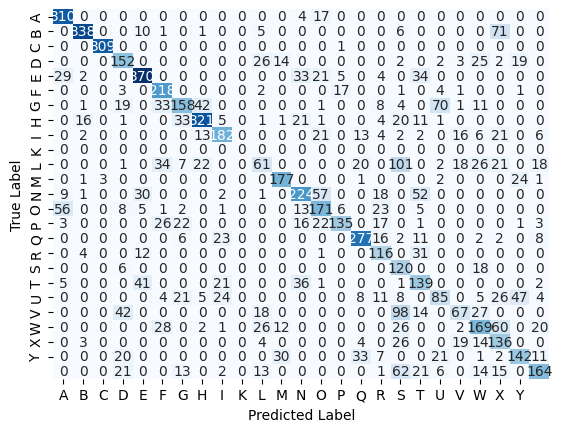

In [ ]:
rnn_confusion_matrix = tf.math.confusion_matrix(Y_test, rnn_test_predictions)

ax = sns.heatmap(rnn_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels = alphabet_filtered, yticklabels = alphabet_filtered, cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

X_train_flat = np.array(X_train)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10]
}

rf_clf = RandomForestClassifier(random_state=7)

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
grid_search.fit(X_train_flat, Y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_rf_clf = grid_search.best_estimator_

rf = best_rf_clf.fit(X_train_flat, Y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .......................max_depth=5, n_estimators=50; total time=   4.3s
[CV] END .......................max_depth=5, n_estimators=50; total time=   6.9s
[CV] END .......................max_depth=5, n_estimators=50; total time=   4.3s
[CV] END ......................max_depth=5, n_estimators=100; total time=   8.5s
[CV] END ......................max_depth=5, n_estimators=100; total time=   8.4s
[CV] END ......................max_depth=5, n_estimators=100; total time=   8.4s
[CV] END ......................max_depth=10, n_estimators=50; total time=   8.9s
[CV] END ......................max_depth=10, n_estimators=50; total time=   9.0s
[CV] END ......................max_depth=10, n_estimators=50; total time=   9.0s
[CV] END .....................max_depth=10, n_estimators=100; total time=  17.7s
[CV] END .....................max_depth=10, n_estimators=100; total time=  18.0s
[CV] END .....................max_depth=10, n_est

In [ ]:
validation_accuracy = grid_search.best_score_
print("Validation Accuracy:", validation_accuracy)

Validation Accuracy: 0.9712985905154111


In [ ]:
X_test_flat = X_test.reshape(X_test.shape[0], -1)
best_rf_clf = grid_search.best_estimator_
Y_pred = best_rf_clf.predict(X_test_flat)
test_accuracy = accuracy_score(Y_test, Y_pred)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.7360568878973787


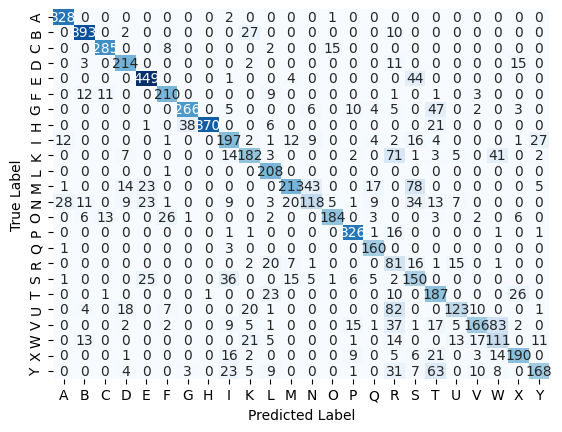

In [ ]:
rf_confusion_matrix = confusion_matrix(Y_test, Y_pred)
ax = sns.heatmap(rf_confusion_matrix, annot=True, fmt='d', cmap='Blues',
                 xticklabels=alphabet_filtered, yticklabels=alphabet_filtered, cbar=False)
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6496521d-ebd8-45fa-91d4-3cac81a166b5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>